# BE Machine Learning

Thomas DOS et Lisa ESCARON

## Présentation du jeu de données

Depuis une rame de métro en service, des mesures de pression, de température, de courant moteur et des volets d'admission d'air ont été relevées sur l'unité de production d'air (APU) d'un compresseur. 

Le jeu de données a été collecté pour permettre le développement de modèles de maintenance prédictive, de détection d’anomalies et de prédiction de la durée de vie restante (RUL) des compresseurs, en utilisant des méthodes d’apprentissage profond et d’apprentissage automatique. Il consiste en des séries temporelles multivariées issues de plusieurs capteurs analogiques et numériques installés sur le compresseur de la rame. Les données couvrent la période de février à août 2020 et comprennent 15 signaux (pressions, courant moteur, température de l’huile, signaux électriques des volets d’admission d’air, etc.). La surveillance et la journalisation des événements industriels (comportement temporel et événements de panne) proviennent des enregistrements générés par les capteurs ; les données ont été consignées à 1 Hz par un dispositif embarqué. 

In [2]:
#Let's import the data and take a look at it
import pandas as pd
df = pd.read_csv("MetroPT3(AirCompressor).csv")

In [3]:
df.tail(10)

,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
1516938,15169380,2020-09-01 03:58:21,-0.012,8.990,8.974,-0.022,8.992,60.075,0.0450,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1516939,15169390,2020-09-01 03:58:31,-0.012,8.974,8.960,-0.022,8.976,60.150,0.0450,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1516940,15169400,2020-09-01 03:58:40,-0.012,8.960,8.946,-0.020,8.962,59.950,0.0450,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1516941,15169410,2020-09-01 03:58:50,-0.012,8.946,8.932,-0.022,8.948,59.850,0.0450,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1516942,15169420,2020-09-01 03:59:00,-0.012,8.934,8.920,-0.022,8.934,59.775,0.0450,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1516943,15169430,2020-09-01 03:59:10,-0.014,8.918,8.906,-0.022,8.918,59.675,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1516944,15169440,2020-09-01 03:59:20,-0.014,8.904,8.888,-0.020,8.904,59.600,0.0450,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1516945,15169450,2020-09-01 03:59:30,-0.014,8.890,8.876,-0.022,8.892,59.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1516946,15169460,2020-09-01 03:59:40,-0.012,8.876,8.864,-0.022,8.878,59.550,0.0450,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1516947,15169470,2020-09-01 03:59:50,-0.014,8.860,8.848,-0.022,8.864,59.475,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [4]:
print(df.shape)

(1516948, 17)


On a 15 signaux mais 17 colonnes car on a deux colonnes supplémentaires : timestamp et la première qui donne un id de la ligne.

# Modèle de détection d'anomalies

Sur la période de février à août 2020, on a un historiques des erreurs et pannes du compresseur. 

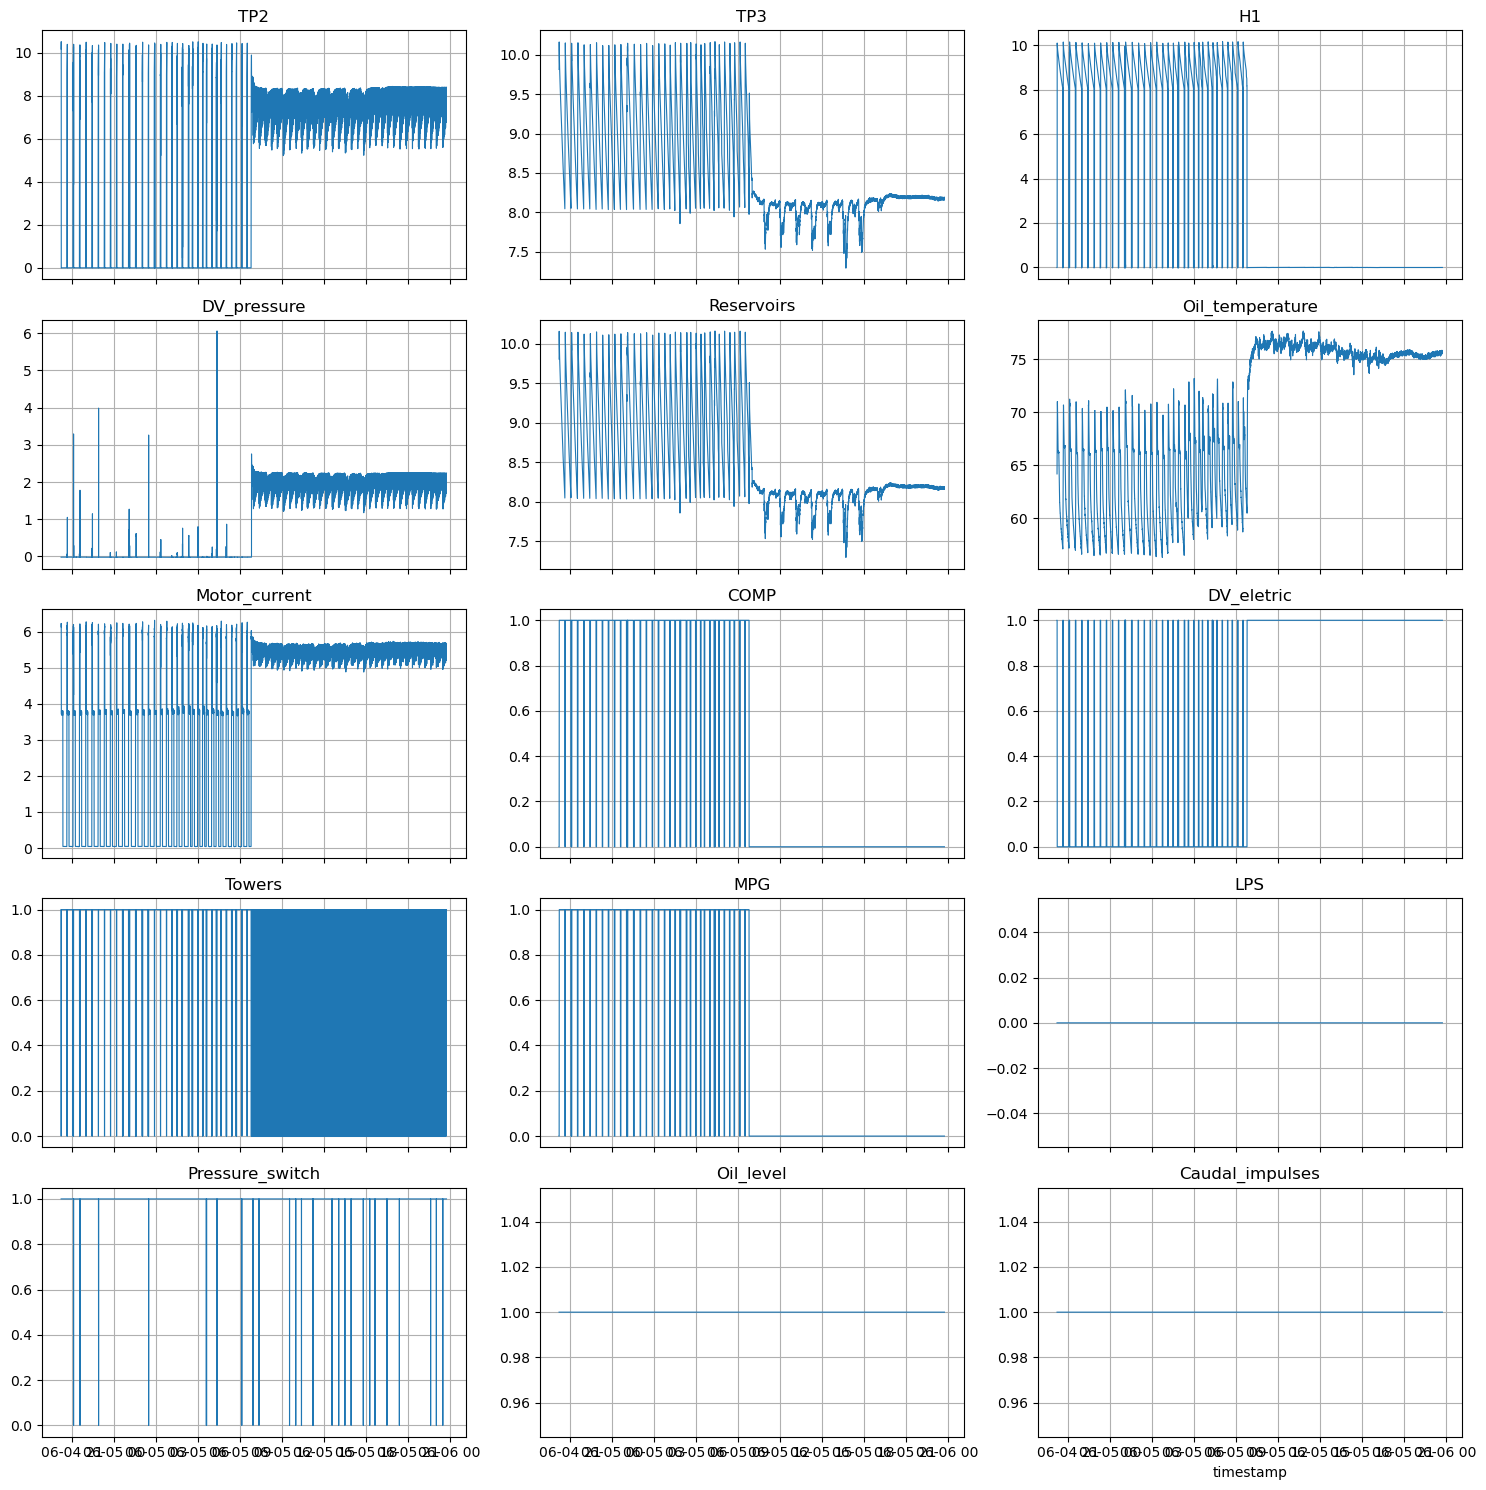

In [5]:
import numpy as np

# Extraire 1000 lignes autour de "2020-04-18 00:00:00"
# (Utilise le dataframe `df` déjà présent dans le notebook.)

# s'assurer que la colonne timestamp est en datetime
if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
    df['timestamp'] = pd.to_datetime(df['timestamp'])

target = pd.to_datetime("6/5/2020 10:00")

# trouver l'index de la ligne la plus proche du target
closest_idx = (df['timestamp'] - target).abs().idxmin()
pos = df.index.get_loc(closest_idx)

n = 10000
half = n // 2
start = max(0, pos - half)
end = start + n
if end > len(df):
    end = len(df)
    start = max(0, end - n)

df_around_failure = df.iloc[start:end].copy()

import matplotlib.pyplot as plt

# select numeric features (exclude index-like columns)
num_cols = df_around_failure.select_dtypes(include='number').columns.tolist()
if 'Unnamed: 0' in num_cols:
    num_cols.remove('Unnamed: 0')

n = len(num_cols)
cols = 3
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows), sharex=True)
axes = axes.flatten()

for i, col in enumerate(num_cols):
    axes[i].plot(df_around_failure['timestamp'], df_around_failure[col], lw=0.8)
    axes[i].set_title(col)
    axes[i].grid(True)

# turn off any unused subplots
for j in range(n, len(axes)):
    axes[j].axis('off')

plt.xlabel('timestamp')
plt.tight_layout()
plt.show()

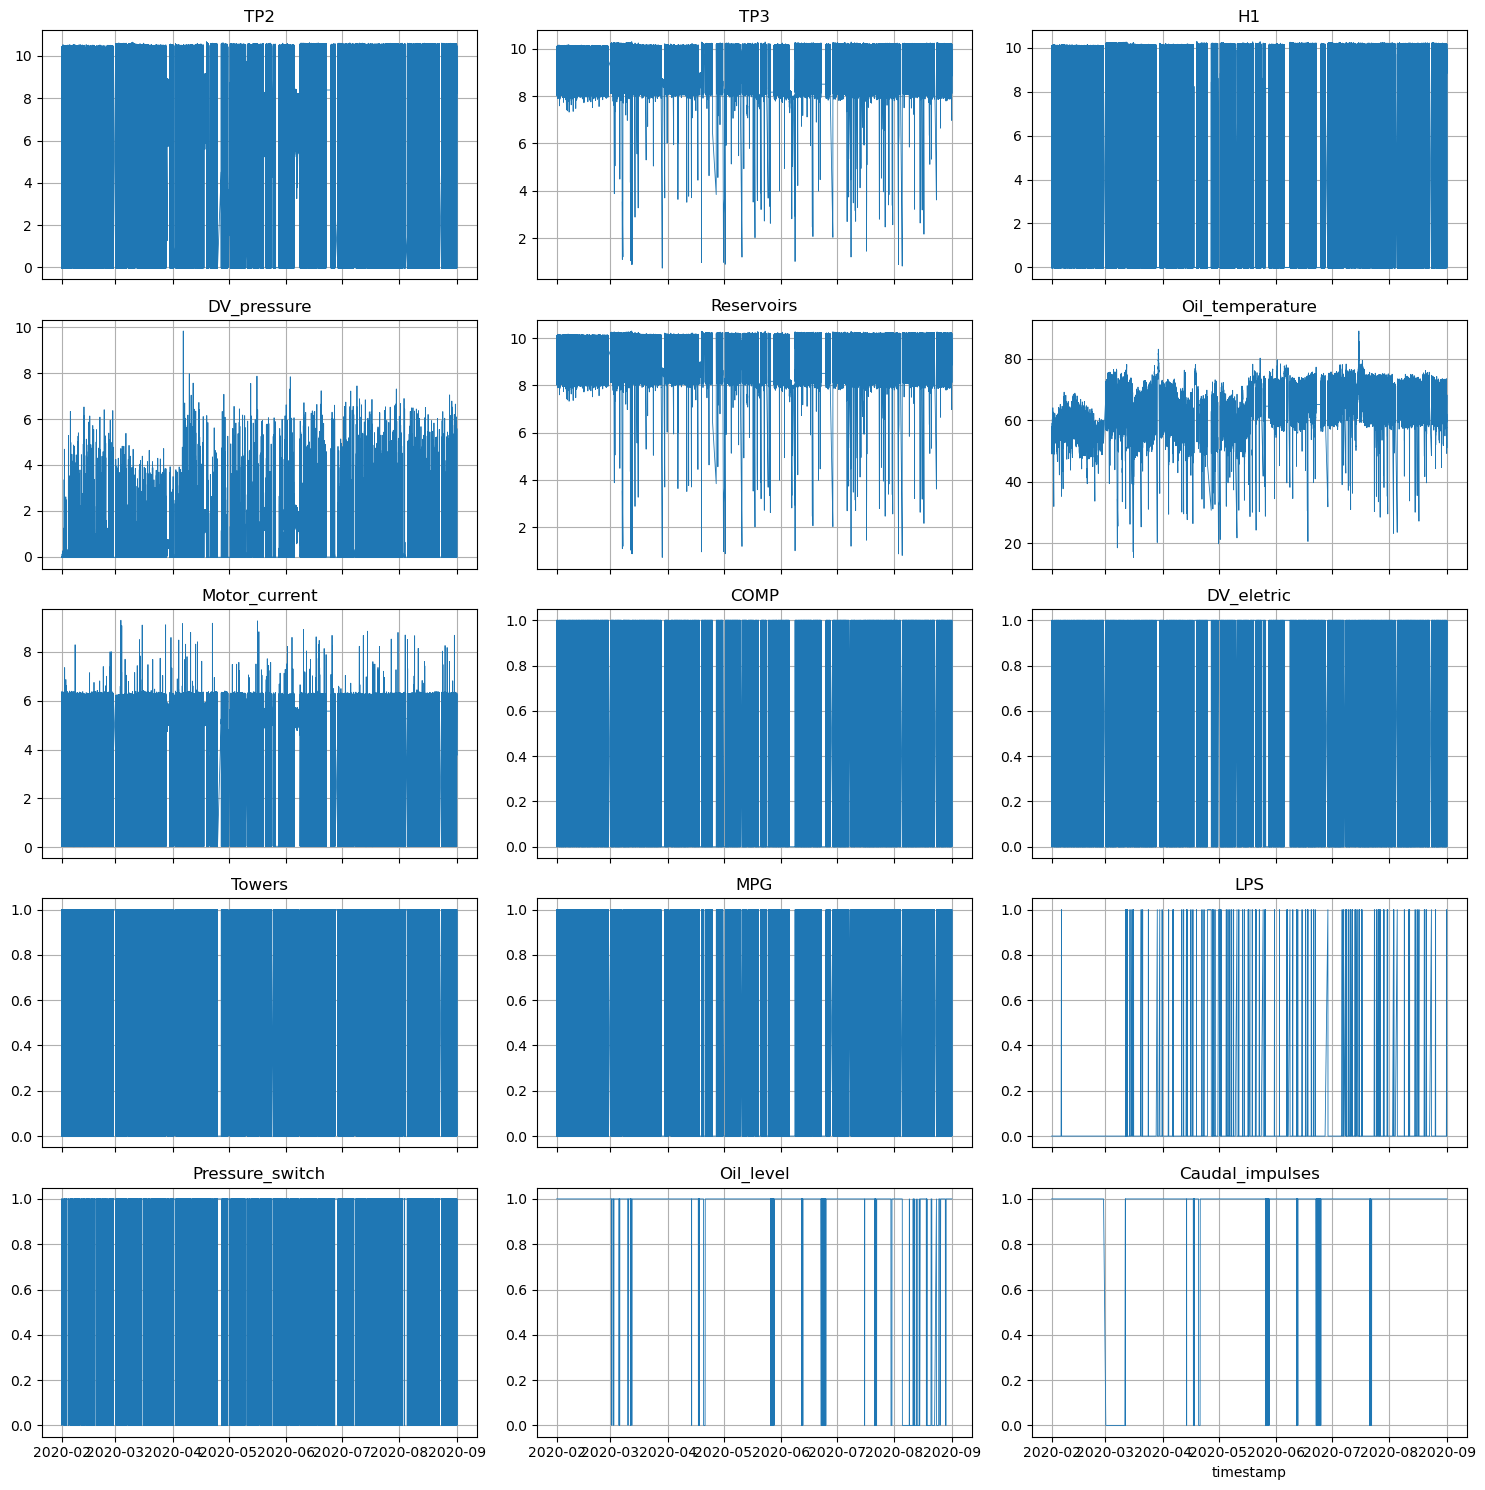

In [6]:
# Plot all numeric signals for the entire dataframe `df`
num_cols = df.select_dtypes(include='number').columns.tolist()
if 'Unnamed: 0' in num_cols:
    num_cols.remove('Unnamed: 0')

n = len(num_cols)
cols = 3
rows = int(np.ceil(n / cols))

fig_full, axes_full = plt.subplots(rows, cols, figsize=(15, 3 * rows), sharex=True)
axes_full = axes_full.flatten()

for i, col in enumerate(num_cols):
    axes_full[i].plot(df['timestamp'], df[col], lw=0.6)
    axes_full[i].set_title(col)
    axes_full[i].grid(True)

for j in range(n, len(axes_full)):
    axes_full[j].axis('off')

plt.xlabel('timestamp')
plt.tight_layout()
plt.show()

In [7]:
#Labelising 
df['failure'] = 0

# 1st failure event
failure_start = pd.to_datetime("4/18/2020 0:00")
failure_end = pd.to_datetime("4/18/2020 23:59")
df.loc[(df['timestamp'] >= failure_start) & (df['timestamp'] <= failure_end), 'failure'] = 1

# 2nd failure event
failure_start = pd.to_datetime("5/29/2020 23:30")
failure_end = pd.to_datetime("5/30/2020 6:00")
df.loc[(df['timestamp'] >= failure_start) & (df['timestamp'] <= failure_end), 'failure'] = 1

# 3rd failure event
failure_start = pd.to_datetime("6/5/2020 10:00")
failure_end = pd.to_datetime("6/7/2020 14:30")
df.loc[(df['timestamp'] >= failure_start) & (df['timestamp'] <= failure_end), 'failure'] = 1

#4th failure event
failure_start = pd.to_datetime("7/15/2020 14:30")
failure_end = pd.to_datetime("7/15/2020 19:00")
df.loc[(df['timestamp'] >= failure_start) & (df['timestamp'] <= failure_end), 'failure'] = 1


In [8]:
from sklearn.model_selection import train_test_split

#Splitting dataset into train and test
# random split (70% train / 30% test), keep class balance with stratify
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, shuffle=True, stratify=df['failure'])

In [10]:
#Train a simple model with a progress bar
from sklearn.ensemble import RandomForestClassifier
from tqdm.auto import tqdm
from sklearn.metrics import classification_report

features = train_df.select_dtypes(include='number').drop(columns=['failure', 'Unnamed: 0']).columns
X_train = train_df[features]
y_train = train_df['failure']

n_estimators = 100
# use warm_start to grow the forest incrementally and show progress
model = RandomForestClassifier(n_estimators=1, random_state=42, warm_start=True, n_jobs=-1)

with tqdm(total=n_estimators, desc="Training RandomForest", unit="est") as pbar:
    for i in range(n_estimators):
        model.n_estimators = i + 1
        model.fit(X_train, y_train)
        pbar.update(1)

# Evaluate the model
X_test = test_df[features]
y_test = test_df['failure']
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

Training RandomForest: 100%|██████████| 100/100 [00:48<00:00,  2.05est/s]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    446099
           1       0.98      0.98      0.98      8986

    accuracy                           1.00    455085
   macro avg       0.99      0.99      0.99    455085
weighted avg       1.00      1.00      1.00    455085



In [11]:
#Logistic Regression model
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    446099
           1       0.75      0.80      0.77      8986

    accuracy                           0.99    455085
   macro avg       0.87      0.90      0.89    455085
weighted avg       0.99      0.99      0.99    455085



In [54]:
#Naive Bayes model
from sklearn.naive_bayes import GaussianNB
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)
y_pred_nb = model_nb.predict(X_test)
print(classification_report(y_test, y_pred_nb))


              precision    recall  f1-score   support

           0       1.00      0.91      0.95    446099
           1       0.18      0.99      0.30      8986

    accuracy                           0.91    455085
   macro avg       0.59      0.95      0.63    455085
weighted avg       0.98      0.91      0.94    455085



In [55]:
#XGBoost model
import xgboost as xgb
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:06:48] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    446099
           1       0.97      0.97      0.97      8986

    accuracy                           1.00    455085
   macro avg       0.98      0.98      0.98    455085
weighted avg       1.00      1.00      1.00    455085



In [13]:
#Bagging Classifier model
from sklearn.ensemble import BaggingClassifier
model_bag = BaggingClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model_bag.fit(X_train, y_train)
y_pred_bag = model_bag.predict(X_test)
print(classification_report(y_test, y_pred_bag))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    446099
           1       0.98      0.98      0.98      8986

    accuracy                           1.00    455085
   macro avg       0.99      0.99      0.99    455085
weighted avg       1.00      1.00      1.00    455085



In [ ]:
#SVM model
from sklearn.svm import SVC
model_svm = SVC(random_state=42)
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))

Training SVM: 64it [00:13,  4.92it/s]


KeyboardInterrupt: 